# Retrieval-based Dialog System on the Ubuntu Dialog Corpus | PyTorch LSTM 

This project is a retrieval-based dialog system, that means a model which classifies whether an utterance is the correct response to a given context utterance or not. Ideally, it is suppose to retrieve the best response to a conversational input from a whole pool of candidate utterances.


Please find the necessary data files within this GDrive folder: https://drive.google.com/open?id=1RIIbsS-vxR7Dlo2_v6FWHDFE7q1XPPgj

You do not need all of these files, it depends on what sample size you would like to try.
--> **To re-run the code as in the documentation below, please do the following:**

1) **Download** the following files only:

    - glove.6B.50d.txt (Subfolder GloVe)
    - training_10000.csv (Subfolder MAIN FILES)
    - validation_1000.csv (Subfolder MAIN FILES)
    - testing_same_structure_1000.csv (Subfolder MAIN FILES)
    - testing_different_structure_100.csv (Subfolder MAIN FILES)
    - saved_model_10000_gpu.pt (Subfolder SAVED MODELS)

2) **Adjust the variables** for *num_training_examples*, *num_validation_examples*, *embedding_dim*, *test_dataframe_same_structure*, *test_dataframe_different_structure* and the *saved model file name* in the marked places in the code.

3) **Adjust the hyperparameter configuration** respectively: in the subfolder SAVED MODELS, along with the model files, you find **screenshots for the models** that tell you the values that were chosen for the hyperparameters in order to achieve the same training & validation results!

==========================================================================================================

**Please note that:**

All of the saved models were trained on a GPU, so if you would like to **test the model**, please **un-comment the ".cuda()"** in the respective parts of the code!

In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.autograd as autograd
from torch.nn import init
import torch.nn.utils.rnn 
import datetime
import operator
from ChaoticLSTM import ChaoticLSTM as clstm
np.random.seed(0)


D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


**Defining helper functions to create variables needed for training and validation**

**Defining model classes**

*Note: According to PyTorch documentation and forum, the in-built dropout in the LSTM will not apply effectively if num_layers = 1 (since it does by definition not apply to the last layer.) Therefore an additional dropout layer was added and the in-built dropout set to 0.0. See http://pytorch.org/docs/master/nn.html#torch.nn.LSTM and https://discuss.pytorch.org/t/dropout-in-lstm/7784*

In [2]:
def create_dataframe(csvfile):
    dataframe = pd.read_csv(csvfile)
    return dataframe

def shuffle_dataframe(dataframe):
    dataframe.reindex(np.random.permutation(dataframe.index))

def create_vocab(dataframe):
    vocab = []
    word_freq = {}

    for index, row in dataframe.iterrows():

        context_cell = row["Context"]
        response_cell = row["Utterance"]

        train_words = str(context_cell).split() + str(response_cell).split()

        for word in train_words:

            if word.lower() not in vocab:
                vocab.append(word.lower())

            if word.lower() not in word_freq:
                word_freq[word.lower()] = 1
            else:
                word_freq[word] += 1

    word_freq_sorted = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    vocab = ["<UNK>"] + [pair[0] for pair in word_freq_sorted]

    return vocab


def create_word_to_id(vocab):
    word_to_id = {word: id for id, word in enumerate(vocab)}

    return word_to_id


def create_id_to_vec(word_to_id, glovefile):
    lines = open(glovefile, 'r', encoding="utf8").readlines()
    # file = open(filename, encoding="utf8")
    id_to_vec = {}
    vector = None

    for line in lines:
        word = line.split()[0]
        vector = np.array(line.split()[1:], dtype='float32') #32

        if word in word_to_id:
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(vector))

    for word, id in word_to_id.items():
        if word_to_id[word] not in id_to_vec:
            v = np.zeros(*vector.shape, dtype='float32')
            v[:] = np.random.randn(*v.shape)*0.01
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(v))

    embedding_dim = id_to_vec[0].shape[0]

    return id_to_vec, embedding_dim


def load_ids_and_labels(row, word_to_id):
    context_ids = []
    response_ids = []

    context_cell = row['Context']
    response_cell = row['Utterance']
    label_cell = row['Label']

    max_context_len = 160

    context_words = context_cell.split()
    if len(context_words) > max_context_len:
        context_words = context_words[:max_context_len]
    for word in context_words:
        if word in word_to_id:
            context_ids.append(word_to_id[word])
        else:
            context_ids.append(0) #UNK

    response_words = response_cell.split()
    for word in response_words:
        if word in word_to_id:
            response_ids.append(word_to_id[word])
        else:
            response_ids.append(0)

    label = np.array(label_cell).astype(np.float32)

    return context_ids, response_ids, label



In [3]:
class Encoder(nn.Module):

    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 p_dropout):

        super(Encoder, self).__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.p_dropout = p_dropout

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        # self.lstm = nn.LSTM(self.emb_size, self.hidden_size)
        self.lstm = clstm(self.emb_size, self.hidden_size, chaotic = True, bidirection = False)
        self.lstm.cuda()
        self.dropout_layer = nn.Dropout(self.p_dropout)

        self.init_weights()

    def init_weights(self):
        # init.uniform(self.lstm.weight_ih_l0, a = -0.01, b = 0.01)
        # init.orthogonal(self.lstm.weight_hh_l0)
        # self.lstm.weight_ih_l0.requires_grad = True
        # self.lstm.weight_hh_l0.requires_grad = True
        init.orthogonal(self.lstm.Wh)
        init.uniform(self.lstm.Wi, a = -0.01, b = 0.01)
        self.lstm.Wi.requires_grad = True
        self.lstm.Wh.requires_grad = True

        embedding_weights = torch.FloatTensor(self.vocab_size, self.emb_size)

        for id, vec in id_to_vec.items():
            embedding_weights[id] = vec

        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = True)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        print("embeddings: ", embeddings.shape)
        _, (last_hidden, _) = self.lstm(embeddings) #dimensions: (num_layers * num_directions x batch_size x hidden_size)
        # print("last_hidden: ", last_hidden.shape)
        # last_hidden = self.dropout_layer(last_hidden[-1])#access last lstm layer, dimensions: (batch_size x hidden_size)
        last_hidden = self.dropout_layer(last_hidden)#access last lstm layer, dimensions: (batch_size x hidden_size)
        return last_hidden


class DualEncoder(nn.Module):

    def __init__(self, encoder):
        super(DualEncoder, self).__init__()
        self.encoder = encoder
        self.hidden_size = self.encoder.hidden_size
        M = torch.FloatTensor(self.hidden_size, self.hidden_size)
        init.xavier_normal(M)
        self.M = nn.Parameter(M, requires_grad = True)

    def forward(self, context_tensor, response_tensor):

        context_last_hidden = self.encoder(context_tensor) #dimensions: (batch_size x hidden_size)
        response_last_hidden = self.encoder(response_tensor) #dimensions: (batch_size x hidden_size)
        # print("context_tensor:", context_tensor.size())
        # print("context_last_hidden:", context_last_hidden.size())
        context = context_last_hidden.mm(self.M).cuda()
        # context = context_last_hidden.mm(self.M) #dimensions: (batch_size x hidden_size)
        context = context.view(-1, 1, self.hidden_size) #dimensions: (batch_size x 1 x hidden_size)
        # print("context:", context.size())
        response = response_last_hidden.view(-1, self.hidden_size, 1) #dimensions: (batch_size x hidden_size x 1)

        score = torch.bmm(context, response).view(-1, 1).cuda()
        # print("score:", score.size())
        # score = torch.bmm(context, response).view(-1, 1) #dimensions: (batch_size x 1 x 1) and lastly --> (batch_size x 1)

        return score


**Defining method to call all helper functions with desired number of examples and embedding dimension (pretrained embedding vectors taken from GloVe file)**

In [4]:
def creating_variables(num_training_examples, num_validation_examples, embedding_dim):

    print(str(datetime.datetime.now()).split('.')[0], "Creating variables for training and validation...")

    training_dataframe = create_dataframe('training_%d.csv' %num_training_examples)
    vocab = create_vocab(training_dataframe)
    word_to_id = create_word_to_id(vocab)
    id_to_vec, emb_dim = create_id_to_vec(word_to_id, 'glove.6B.%dd.txt' %embedding_dim)

    validation_dataframe = create_dataframe('validation_%d.csv' %num_validation_examples)

    print(str(datetime.datetime.now()).split('.')[0], "Variables created.\n")
    
    return training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe
     

**Defining method to create model instance with desired hyperparameters (we only vary hidden_size and p_dropout)**

In [5]:
def creating_model(hidden_size, p_dropout):

    print(str(datetime.datetime.now()).split('.')[0], "Calling model...")

    encoder = Encoder(
            emb_size = emb_dim,
            hidden_size = hidden_size,
            vocab_size = len(vocab),
            p_dropout = p_dropout)

    dual_encoder = DualEncoder(encoder)

    print(str(datetime.datetime.now()).split('.')[0], "Model created.\n")
    print(dual_encoder)
    
    return encoder, dual_encoder

**Some additional helper methods for training and validation**

In [6]:
def increase_count(correct_count, score, label):
    if ((score.data[0][0] >= 0.5) and (label.data[0][0] == 1.0)) or ((score.data[0][0] < 0.5) and (label.data[0][0]  == 0.0)):
       correct_count +=1  
   
    return correct_count

def get_accuracy(correct_count, dataframe):
    accuracy = correct_count/(len(dataframe))
        
    return accuracy
        

**Defining training and validation method**

In [7]:
from matplotlib import pyplot as plt


def train_model(learning_rate, l2_penalty, epochs):
    print(str(datetime.datetime.now()).split('.')[0], "Starting training and validation...\n")
    print("====================Data and Hyperparameter Overview====================\n")
    print("Number of training examples: %d, Number of validation examples: %d" %(len(training_dataframe), len(validation_dataframe)))
    print("Learning rate: %.5f, Embedding Dimension: %d, Hidden Size: %d, Dropout: %.2f, L2:%.10f\n" %(learning_rate, emb_dim, encoder.hidden_size, encoder.p_dropout, l2_penalty))
    print("================================Results...==============================\n")

    optimizer = torch.optim.Adam(dual_encoder.parameters(), lr = learning_rate, weight_decay = l2_penalty)
    loss_func = torch.nn.BCEWithLogitsLoss()
    loss_func.cuda()
    best_validation_accuracy = 0.0
     
    for epoch in range(epochs): 
                     
            shuffle_dataframe(training_dataframe)
            sum_loss_training = 0.0
            training_correct_count = 0
            dual_encoder.train()

            for index, row in training_dataframe.iterrows():            
            
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1), requires_grad = False).cuda()
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1), requires_grad = False).cuda()
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1))), requires_grad = False).cuda()
                             
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                sum_loss_training += loss.data
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                training_correct_count = increase_count(training_correct_count, score, label)
                                                    
            training_accuracy = get_accuracy(training_correct_count, training_dataframe)
            plt.plot(epoch, training_accuracy)
                
            shuffle_dataframe(validation_dataframe)
            
            validation_correct_count = 0
            sum_loss_validation = 0.0
            dual_encoder.eval()

            for index, row in validation_dataframe.iterrows():
                
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)).cuda()
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)).cuda()
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))).cuda()
                
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                sum_loss_validation += loss.data
                validation_correct_count = increase_count(validation_correct_count, score, label)
                    
            validation_accuracy = get_accuracy(validation_correct_count, validation_dataframe)
                        
            print(str(datetime.datetime.now()).split('.')[0], 
                  "Epoch: %d/%d" %(epoch,epochs),  
                  "TrainLoss: %.3f" %(sum_loss_training/len(training_dataframe)), 
                  "TrainAccuracy: %.3f" %(training_accuracy), 
                  "ValLoss: %.3f" %(sum_loss_validation/len(validation_dataframe)), 
                  "ValAccuracy: %.3f" %(validation_accuracy))
            
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                torch.save(dual_encoder.state_dict(), 'saved_model_%d_examples.pt' %(len(training_dataframe)))
                print("New best found and saved.")
                
    print(str(datetime.datetime.now()).split('.')[0], "Training and validation epochs finished.")


**Choosing data size and embedding dimension, creating variables needed for training and validation**

In [8]:
training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe = creating_variables(num_training_examples = 1000,
                                                                                                     embedding_dim = 50,
                                                                                                     num_validation_examples = 100)

2022-11-08 01:58:21 Creating variables for training and validation...
2022-11-08 01:58:31 Variables created.



**Choosing hidden size and dropout probability, creating model**

2022-11-08 01:58:31 Calling model...


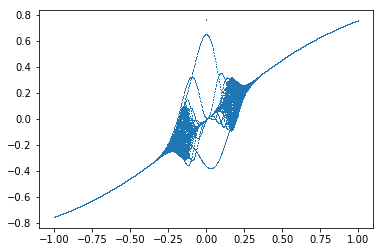

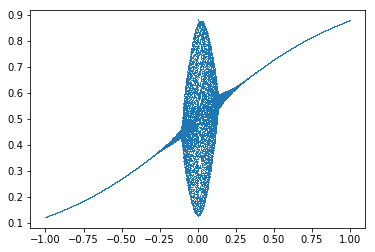

[[ 0.00000000e+00 -7.61594176e-01 -7.61594176e-01 ... -7.61594176e-01
  -7.61594176e-01 -7.61594176e-01]
 [ 1.00000000e+00 -7.60752916e-01 -7.60752916e-01 ... -7.60752916e-01
  -7.60752916e-01 -7.60752916e-01]
 [ 2.00000000e+00 -7.59909153e-01 -7.59909153e-01 ... -7.59909153e-01
  -7.59909153e-01 -7.59909153e-01]
 ...
 [ 9.97000000e+02  7.59062767e-01  7.59062767e-01 ...  7.59062767e-01
   7.59062767e-01  7.59062767e-01]
 [ 9.98000000e+02  7.59909153e-01  7.59909153e-01 ...  7.59909153e-01
   7.59909153e-01  7.59909153e-01]
 [ 9.99000000e+02  7.60752916e-01  7.60752916e-01 ...  7.60752916e-01
   7.60752916e-01  7.60752916e-01]]
[[0.00000000e+00 1.19202912e-01 1.19202912e-01 ... 1.19202912e-01
  1.19202912e-01 1.19202912e-01]
 [1.00000000e+00 1.19623542e-01 1.19623542e-01 ... 1.19623542e-01
  1.19623542e-01 1.19623542e-01]
 [2.00000000e+00 1.20045424e-01 1.20045424e-01 ... 1.20045424e-01
  1.20045424e-01 1.20045424e-01]
 ...
 [9.97000000e+02 8.79531384e-01 8.79531384e-01 ... 8.79531384e

D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.


2022-11-08 01:59:21 Model created.

DualEncoder(
  (encoder): Encoder(
    (embedding): Embedding(6885, 50)
    (lstm): ChaoticLSTM()
    (dropout_layer): Dropout(p=0.85, inplace=False)
  )
)
M
encoder.embedding.weight
encoder.lstm.Wi
encoder.lstm.Wh
encoder.lstm.B


D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\ipykernel_launcher.py:30: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
D:\ProgramFiles\Anaconda\envs\rinL\lib\site-packages\ipykernel_launcher.py:58: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [9]:
encoder, dual_encoder = creating_model(hidden_size = 50, 
                                       p_dropout = 0.85)

encoder.cuda()
dual_encoder.cuda()

for name, param in dual_encoder.named_parameters():
    if param.requires_grad:
        print(name)

**Choosing learning rate and number of epochs, starting training and validation epochs**

In [10]:
train_model(learning_rate = 0.0001,
            l2_penalty = 0.0001,
            epochs = 100)

2022-11-08 01:59:21 Starting training and validation...

====================Data and Hyperparameter Overview====================

Number of training examples: 1000, Number of validation examples: 100
Learning rate: 0.00010, Embedding Dimension: 50, Hidden Size: 50, Dropout: 0.85, L2:0.0001000000

================================Results...==============================

embeddings:  torch.Size([106, 1, 50])
embeddings:  torch.Size([8, 1, 50])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [106, 50] but got: [8, 50].

**Loading saved model for testing**

In [ ]:
dual_encoder.load_state_dict(torch.load('saved_model_1000_examples.pt'))

dual_encoder.eval()

**Testing approach 1:**

*Test data has same structure as training and validation data (context, response, label)*

*Test metric: Accuracy*

Loading data:

In [ ]:
test_dataframe_same_structure = pd.read_csv('testing_same_structure_100.csv')

Defining method to compute scores and accuracy:

In [ ]:
def testing_same_structure():
    
    test_correct_count = 0

    for index, row in test_dataframe_same_structure.iterrows():

        context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
        context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)).cuda()
        response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)).cuda()
        label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))).cuda()

        score = dual_encoder(context, response)
        test_correct_count = increase_count(test_correct_count, score, label)

    test_accuracy = get_accuracy(test_correct_count, test_dataframe_same_structure)
    
    return test_accuracy

Accuracy:

In [ ]:
test_accuracy = testing_same_structure()
print("Test accuracy for %d training examples and %d test examples: %.2f" %(len(training_dataframe),len(test_dataframe_same_structure),test_accuracy))

**Testing approach 2**

*Test data has different structure than training and validation data (1 context utterance, 1 ground truth utterance, 9 distractor utterances)*

*Test metric: Recall*

Loading data:

In [ ]:
test_dataframe_different_structure = pd.read_csv('testing_different_structure_100.csv')

Defining method to store each example's word IDs per utterance in a dictionary:

*Outer dictionary "ids_per_example_and_candidate": keys = examples, values = inner dictionaries*

*Inner dictionaries "ids_per_candidate": keys = candidate names, values = list of word IDs*

In [ ]:
def load_ids(test_dataframe_different_structure, word_to_id):
    
    print(str(datetime.datetime.now()).split('.')[0], "Loading test IDs...")

    max_context_len = 160
    ids_per_example_and_candidate = {}
    
    for i, example in test_dataframe_different_structure.iterrows():
        
        ids_per_candidate = {}
        for column_name, cell in  example.iteritems():
            
                id_list = []
                words = str(cell).split()
                if len(words) > max_context_len:
                    words = words[:max_context_len]
    
                for word in words:
                    if word in word_to_id:
                        id_list.append(word_to_id[word])
                    else: 
                        id_list.append(0) #UNK  
                    
                ids_per_candidate[column_name] = id_list
    
        ids_per_example_and_candidate[i] = ids_per_candidate
    
    print(str(datetime.datetime.now()).split('.')[0], "Test IDs loaded.")
    
    return ids_per_example_and_candidate

In [ ]:
ids_per_example_and_candidate = load_ids(test_dataframe_different_structure, word_to_id)

Defining method to store each example's scores per utterance in a dictionary: (in analogy to above)

*Outer dictionary "scores_per_example_and_candidate": keys = examples, values = inner dictionaries*

*Inner dictionaries "scores_per_candidate": keys = candidate names, values = score*

In [ ]:
def load_scores(): 
    print(str(datetime.datetime.now()).split('.')[0], "Computing test scores...")
    scores_per_example_and_candidate = {}
                 
    for example, utterance_ids_dict in sorted(ids_per_example_and_candidate.items()): 
        
        score_per_candidate = {}
        for utterance_name, ids_list in sorted(utterance_ids_dict.items()):
        
            context = autograd.Variable(torch.LongTensor(utterance_ids_dict['Context']).view(-1,1)).cuda()
            if utterance_name != 'Context':
                candidate_response = autograd.Variable(torch.LongTensor(utterance_ids_dict[utterance_name]).view(-1, 1)).cuda()
                score = torch.sigmoid(dual_encoder(context, candidate_response))
                score_per_candidate["Score with " + utterance_name] = score.data[0][0]
    
        scores_per_example_and_candidate[example] = score_per_candidate

    print(str(datetime.datetime.now()).split('.')[0], "Test scores computed.")
    
    return scores_per_example_and_candidate


In [ ]:
scores_per_example_and_candidate = load_scores()

Defining method to compute results for recall metric: 

*If 1 in 10 utterances (1 ground truth + 9 distractors) is the correct response to a context utterance, what's the chance that the ground truth utterance is among the utterances with the k = 5,2,1 highest scores?*

In [ ]:
def get_recall_at_k(k):
    count_true_hits = 0
    
    for example, score_per_candidate_dict in sorted(scores_per_example_and_candidate.items()): 
    
        top_k = dict(sorted(score_per_candidate_dict.items(), key=operator.itemgetter(1), reverse=True)[:k])
        if 'Score with Ground Truth Utterance' in top_k:
            count_true_hits += 1
    
    number_of_examples = len(scores_per_example_and_candidate)
    recall_at_k = count_true_hits/number_of_examples
    
    return recall_at_k


In [ ]:
print("recall_at_5 =",get_recall_at_k(k = 5)) #Baseline expectation: 5/10 = 0.5 for random guess
print("recall_at_2 =",get_recall_at_k(k = 2)) #Baseline expectation: 2/10 = 0.2 for random guess
print("recall_at_1 =",get_recall_at_k(k = 1)) #Baseline expectation: 1/10 = 0.1 for random guess